# Combine spectroscopic properties, rotation periods and distances to get precise ages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
import emcee
import priors
import corner

Load the crossmatched data file with Gaia data, CKS spectroscopic properties and rotation periods.

In [2]:
df1 = pd.read_csv("kane_cks_tdmra_dr2.csv")

# Load the Sanders catalogue and merge with the CKS one.
file = "gaia_spectro.hdf5"
data = Table.read(file)
sanders = data.to_pandas()
df2 = pd.merge(df1, sanders, on="source_id", suffixes=["", "_sanders"])

In [3]:
def distance_modulus(m, parallax_mas):
    D_pc = 1./(parallax_mas * 1e-3)
    return m + 5 - 5*np.log10(D_pc)

CKS/rotation period sample.

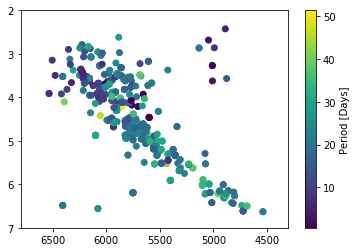

In [4]:
plt.scatter(df1.teff, distance_modulus(df1.phot_g_mean_mag, df1.parallax), c=df1.period)
plt.ylim(7, 2)
plt.xlim(6800, 4300)
plt.colorbar(label="Period [Days]")

CKS/rotation period/Sanders sample

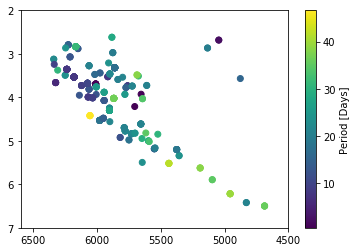

In [5]:
plt.scatter(df2.teff, distance_modulus(df2.phot_g_mean_mag, df2.parallax), c=df2.period)
plt.ylim(7, 2)
plt.xlim(6600, 4500)
plt.colorbar(label="Period [Days]")

Cut out giants.

(144, 306)
4.559014265604383


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


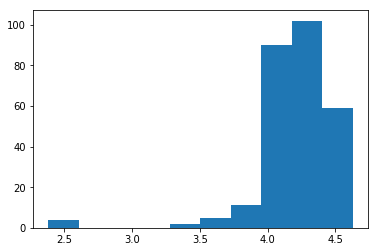

In [6]:
plt.hist(df2.logg.values[np.isfinite(df2.logg.values)]);

m = 4.2 < df2.logg.values
m &= df2.teff.values < 6250
df = df2.iloc[m]
print(np.shape(df))
print(df.logg.values[0])

#for i in df.keys():
#    print(i)

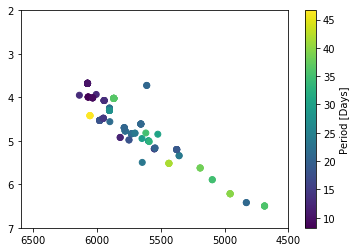

In [7]:
plt.scatter(df.teff, distance_modulus(df.phot_g_mean_mag, df.parallax), c=df.period)
plt.ylim(7, 2)
plt.xlim(6600, 4500)
plt.colorbar(label="Period [Days]")

Calculate B-V colours for Gaia stars using their Bp-Rp colours.

In [8]:
def bv_2_bprp(bv):
    """
    Numbers from https://arxiv.org/pdf/1008.0815.pdf
    """
    a, b, c, d = .0981, 1.4290, -.0269, .0061  # sigma = .43
    return a + b*bv + c*bv**2 + d*bv**3

def bprp_2_bv(bprp):
    """
    Try to find the analytic version of this, please!
    """
    bv_iter = np.linspace(0., 2., 10000)
    bprp_pred = [bv_2_bprp(bv) for bv in bv_iter]
    diffs = bprp - np.array(bprp_pred)
    # plt.plot(bprp_pred, diffs**2)
    return bv_iter[np.argmin(diffs**2)]

bv_color = []
for i in range(np.shape(df)[0]):
    bv_color.append(bprp_2_bv(df.phot_bp_mean_mag.values[i] - df.phot_rp_mean_mag.values[i]))
df["BV_color"] = np.array(bv_color)

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Combine isochrones.py with a gyro model to get ages.

In [9]:
# Set up the stuff needed by isochrones.py

mist = MIST_Isochrone()

i = 0  # Just run on the first star.
print(df.source_id.values[i])

# Set the initial values
mass_init = df.iso_smass.values[i]
age_init = 2e9
feh_init = df.cks_smet.values[i]
distance_init = 1./df.parallax.values[i]
Av_init = .1

# sample in ln(mass), log10(age) and ln(distance).
p_init = np.array([np.log(mass_init), np.log10(age_init), feh_init, np.log(distance_init), Av_init])

# Set up the StarModel object needed to calculate the likelihood. 
param_dict = {"J": (df.jmag.values[i], df.jmag.values[i]*.05),
              "H": (df.hmag.values[i], df.hmag.values[i]*.05),
              "K": (df.kmag.values[i], df.kmag.values[i]*.05),
              "teff": (df.cks_steff.values[i], df.cks_steff_err1.values[i]),
              "logg": (df.cks_slogg.values[i], df.cks_slogg_err1.values[i]),
              "feh": (df.cks_smet.values[i], df.cks_smet_err1.values[i]),
              "parallax": (df.parallax.values[i],
                           (df.parallax_error.values[i]))}  # Isochrones.py takes milliarcseconds


# test with Solar values
param_dict = {"V": (4.83, .01),
              "teff": (5770, 10),
              "logg": (4.44, .05),
              "feh": (0, .01),
              "parallax": (100, 1)
             }  # Isochrones.py takes milliarcseconds


mod = StarModel(mist, **param_dict)

2.0732772002376945e+18


Define the gyrochronology model. I'm using the Barnes (2003) functional form with my (2015) parameters.

In [10]:
def gyro_model(ln_age, bv):
    """
    Given a B-V colour and an age, predict a rotation period.
    Returns log(age) in Myr.
    parameters:
    ----------
    logage: (array)
        The log age of a star: log10(age) in years.
    bv: (array)
        The B-V colour of a star.
    """
    age_myr = (10**ln_age)*1e-6
    
    a, b, c, n = [.4, .31, .45, .55]
    
    # return a*(age_myr)**n * (bv - c)**b
    log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
    return 10**log_P

Define the log prior and the log posterior functions.

In [15]:
def lnprior(params):
    """
    lnprior on all parameters.
    params need to be linear except age which is log10(age [yr]).
    """
    
    # log Priors over age, metallicity and distance. (The priors in priors.py are not in log)
    age_prior = np.log(priors.age_prior(params[1]))
    feh_prior = np.log(priors.feh_prior(params[2]))
    distance_prior = np.log(priors.distance_prior(np.exp(params[3])))

    # Uniform prior on extinction.
    mAv = (0 <= params[4]) * (params[4] < 1)  # Prior on A_v
    mAv = mAv == 1
    
    # Uniform prior on mass
    m = (-20 < params[0]) * (params[0]) < 20  # Broad bounds on mass.
            
    if mAv and m and np.isfinite(age_prior) and np.isfinite(distance_prior):
        return age_prior + feh_prior + distance_prior
    
    else:
        return -np.inf

    
def lnprob(lnparams, *args):
    # Transform mass and distance back to linear.
    params = lnparams*1
    params[0] = np.exp(lnparams[0])
    params[3] = np.exp(lnparams[3])
    
    mod, period, period_err, bv_est, gyro_only, iso_only = args
    
    B = mist.mag["B"](*params)
    V = mist.mag["V"](*params)
    bv = B-V
    
    # If the prior is -inf, don't even try to calculate the isochronal likelihood.
    lnpr = lnprior(params)
    if lnpr == -np.inf:
        return lnpr
    
    else:
    
        if iso_only:
            return mod.lnlike(params) + lnpr
        
        else:
            if bv > .45:
                gyro_lnlike = -.5*((period - gyro_model(params[1], bv)) /period_err)**2
            else:
                gyro_lnlike = 0
    
        # B-V is estimated from mass, etc, so you need to use a different B-V estimate if gyro_only.
        if gyro_only:
            return -.5*((period - gyro_model(params[1], bv_est)) /period_err)**2 + lnpr
    
        else:
            return mod.lnlike(params) + gyro_lnlike + lnpr
            #return lnpr

Test the lnprob (you have to 'unstar' args above for this to work. Put it back for the next cell, though)

In [13]:
ndim, nwalkers = 5, 24
args = [mod, df.period.values[i], .5*(df.period_errm.values[i] + df.period_errp.values[i]),
        df.BV_color.values[i], False, False]

# test with Solar values.
args = [mod, 26, 1, .65, False, False]

In [14]:
#print(lnprob(p_init, args))
#print(lnprob(p_init + np.random.randn(ndim)*1e-4, args))

-5068362.542911708
-5069060.115004163


Run the MCMC.

In [16]:
p0 = [p_init + np.random.randn(ndim)*1e-4 for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
p0, _, _ = sampler.run_mcmc(p0, 5000);

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


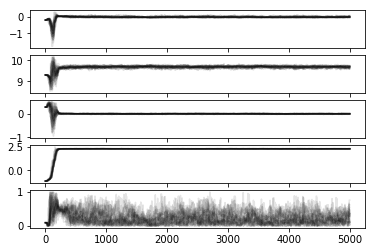

In [17]:
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.plot(sampler.chain[:, :, i].T, "k", alpha=.1)
    #plt.ylabel(labels[i])

In [18]:
sampler.reset()
sampler.run_mcmc(p0, 10000);

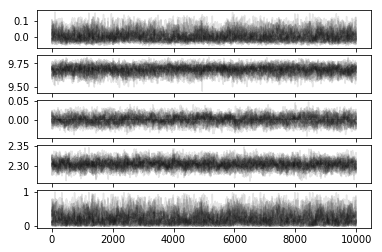

In [19]:
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.plot(sampler.chain[:, :, i].T, "k", alpha=.1)
    #plt.ylabel(labels[i])

Plot the results in linear space.

(240000, 5)


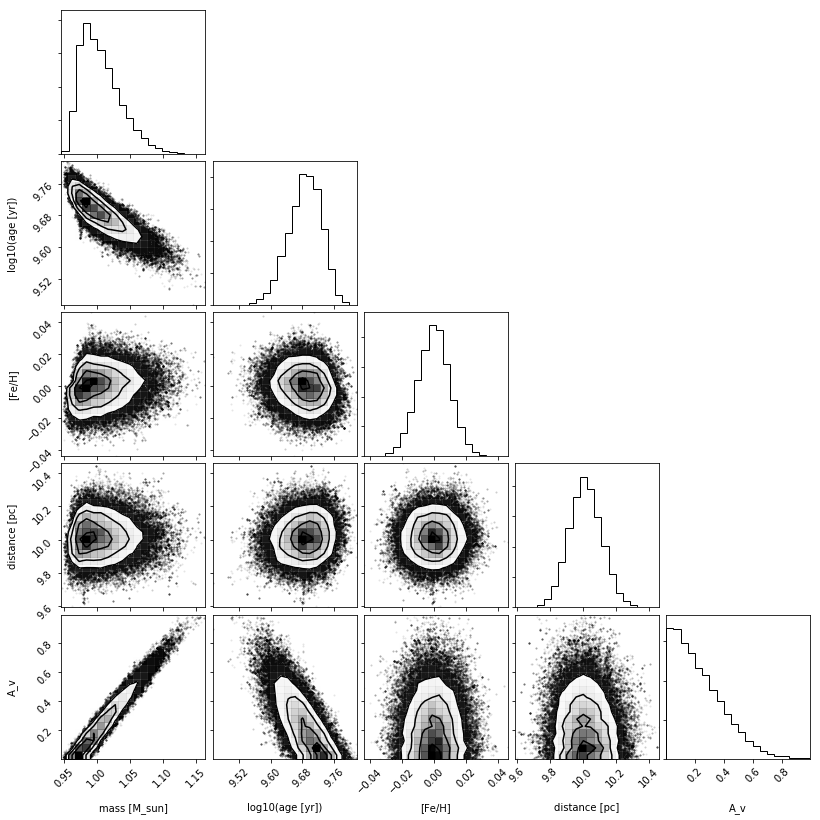

In [20]:
samples = sampler.flatchain
print(np.shape(samples))
samples[:, 0] = np.exp(samples[:, 0])
samples[:, 3] = np.exp(samples[:, 3])
labels = ["mass [M_sun]", "log10(age [yr])", "[Fe/H]", "distance [pc]", "A_v"]
corner.corner(samples, labels=labels);

Plot the marginalised posterior over age.

age =  4.872707265655496


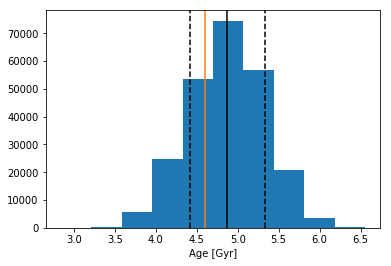

In [21]:
age_gyr = 10**samples[:, 1]*1e-9
plt.hist(age_gyr)
plt.xlabel("Age [Gyr]")
med, std = np.median(age_gyr), np.std(age_gyr)
plt.axvline(med, color="k")
plt.axvline(4.603, color="tab:orange")
plt.axvline(med - std, color="k", linestyle="--")
plt.axvline(med + std, color="k", linestyle="--")
print("age = ", med)

What's the gyro age?

How much of this is coming from gyrochronology and how much from isochrones?
What's the rotation predicted by gyrochronology?

In [22]:
def gyro_model_age(period, bv):
    
    a, b, c, n = [.4, .31, .45, .55]
    log_A = (np.log10(period) - np.log10(a) - b*np.log10(bv-c))/n
    return 10**log_A

def gyro_model_period(age_myr, bv):
    a, b, c, n = [.4, .31, .45, .55]
    log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
    return 10**log_P

In [23]:
print("predicted age = ", med, "Gyr +/-", std)
print("measured period = ", df.period.values[0], "days")
print("predicted period = ", gyro_model_period(10**np.median(samples[:, 1])*1e-6, df.BV_color.values[0]))

predicted age =  4.872707265655496 Gyr +/- 0.45782939069736855
measured period =  39.72376624264529 days
predicted period =  32.02667798726373


What happens if you just use an isochronal likelihood function?

In [24]:
# Test the lhf
args = [mod, df.period.values[i], .5*(df.period_errm.values[i] + df.period_errp.values[i]),
        df.BV_color.values[i], False, True]

# For the Sun
args = [mod, 26, 1, 0.65, False, True]

In [25]:
#print(lnprob(p_init, args))
#print(lnprob(p_init + np.random.randn(ndim)*1e-4, args))

In [26]:
# Run MCMC
p0 = [p_init + np.random.randn(ndim)*1e-4 for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
p0, _, _ = sampler.run_mcmc(p0, 5000);
sampler.reset()
sampler.run_mcmc(p0, 10000);

samples = sampler.flatchain
samples[:, 0] = np.exp(samples[:, 0])
samples[:, 1] = 10**samples[:, 1]*1e-9
samples[:, 3] = np.exp(samples[:, 3])

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


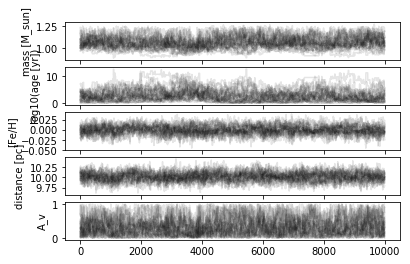

In [27]:
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.plot(sampler.chain[:, :, i].T, "k", alpha=.1)
    plt.ylabel(labels[i])

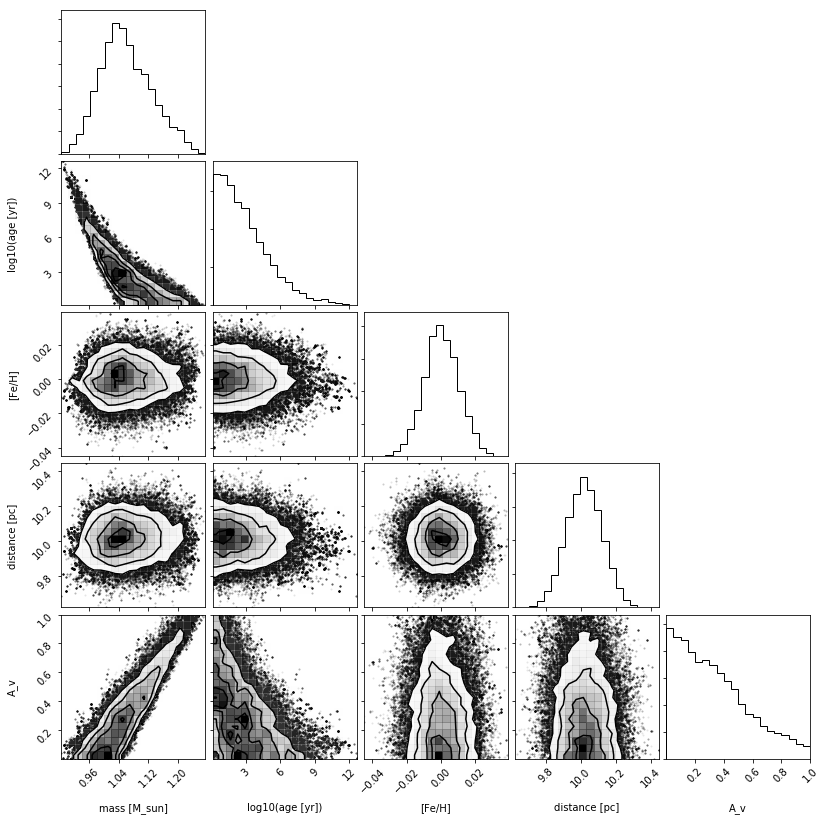

In [28]:
corner.corner(samples, labels=["mass [M_sun]", "log10(age [yr])", "[Fe/H]", "distance [pc]", "A_v"]);

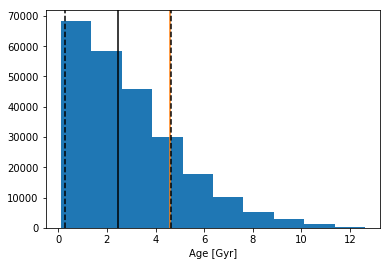

In [29]:
age_gyr = samples[:, 1]
plt.hist(age_gyr)
plt.xlabel("Age [Gyr]")
med, std = np.median(age_gyr), np.std(age_gyr)
plt.axvline(med, color="k")
plt.axvline(4.603, color="tab:orange")
plt.axvline(med - std, color="k", linestyle="--")
plt.axvline(med + std, color="k", linestyle="--")

In [30]:
print("predicted age = ", med, "Gyr +/-", std)

predicted age =  2.440712897180264 Gyr +/- 2.1808482700047187


What about just a rotation period lhf?

In [31]:
# Test the lhf
args = [mod, df.period.values[i], .5*(df.period_errm.values[i] + df.period_errp.values[i]),
        df.BV_color.values[i]]

# For the Sun
args = [mod, 26, 1,.65, True, False]

In [32]:
#print(lnprob(p_init, args))
#print(lnprob(p_init + np.random.randn(ndim)*1e-4, args))

In [33]:
# Run MCMC
p0 = [p_init + np.random.randn(ndim)*1e-4 for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
p0, _, _ = sampler.run_mcmc(p0, 5000);
sampler.reset()
sampler.run_mcmc(p0, 10000);

samples = sampler.flatchain
samples[:, 0] = np.exp(sampler.flatchain[:, 0])
samples[:, 1] = 10**samples[:, 1]*1e-9
samples[:, 3] = np.exp(sampler.flatchain[:, 3])

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp
/Users/ruthangus/projects/habitablezoning/priors.py:34: RuntimeWarning: overflow encountered in double_scalars
  return 3/max_distance**3 * distance**2
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: overflow encountered in exp


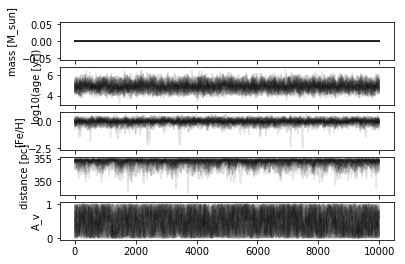

In [34]:
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.plot(sampler.chain[:, :, i].T, "k", alpha=.1)
    plt.ylabel(labels[i])

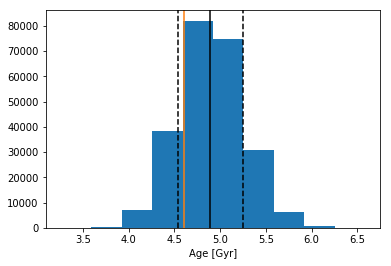

In [35]:
age_gyr = samples[:, 1]
plt.hist(age_gyr)
plt.xlabel("Age [Gyr]")
med, std = np.median(age_gyr), np.std(age_gyr)
plt.axvline(med, color="k")
plt.axvline(4.603, color="tab:orange")
plt.axvline(med - std, color="k", linestyle="--")
plt.axvline(med + std, color="k", linestyle="--")

In [36]:
print("predicted age = ", med, "Gyr +/-", std)

predicted age =  4.894268655610623 Gyr +/- 0.35325696277395036


Sample from the priors.

In [37]:
args = [mod, 26, 1,.65, False, False]

# Run MCMC
p0 = [p_init + np.random.randn(ndim)*1e-4 for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
p0, _, _ = sampler.run_mcmc(p0, 5000);
sampler.reset()
sampler.run_mcmc(p0, 10000);

samples = sampler.flatchain
samples[:, 0] = np.exp(sampler.flatchain[:, 0])
samples[:, 1] = 10**samples[:, 1]*1e-9
samples[:, 3] = np.exp(sampler.flatchain[:, 3])

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


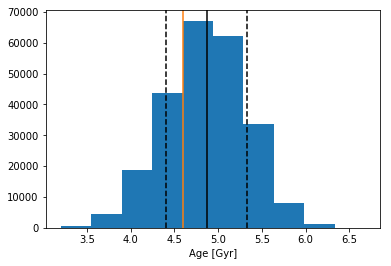

In [36]:
age_gyr = samples[:, 1]
plt.hist(age_gyr)
plt.xlabel("Age [Gyr]")
med, std = np.median(age_gyr), np.std(age_gyr)
plt.axvline(med, color="k")
plt.axvline(4.603, color="tab:orange")
plt.axvline(med - std, color="k", linestyle="--")
plt.axvline(med + std, color="k", linestyle="--")